<a href="https://colab.research.google.com/github/solharsh/Data_Understanding_And_Preparation/blob/master/Lending_Club_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [11]:
# Import our libraries we are going to use for our data analysis.
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Other Libraries
import time

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
start_df = pd.read_csv("/content/drive/My Drive/Capstone Project - NLP/fullacc.csv",low_memory=False)

Working on a copy of the dataframe so that I do not have to re-read the entire dataset again in order to save memory.

In [0]:
df = start_df.copy(deep=True)
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,1077501,NaN,5000,5000,4975.0,36 months,0.1065,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,0.002765,0.0,Jan-85,735,739,1.0,NaN,NaN,3.0,0.0,13648,83.70%,9.0,f,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,NaN,2500,2500,2500.0,60 months,0.1527,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,0.000100,0.0,Apr-99,740,744,5.0,NaN,NaN,3.0,0.0,1687,9.40%,4.0,f,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,NaN,2400,2400,2400.0,36 months,0.1596,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,0.000872,0.0,Nov-01,735,739,2.0,NaN,NaN,2.0,0.0,2956,98.50%,10.0,f,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,NaN,10000,10000,10000.0,36 months,0.1349,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,0.002000,0.0,Feb-96,690,694,1.0,35.0,NaN,10.0,0.0,5598,21%,37.0,f,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,NaN,3000,3000,3000.0,60 months,0.1269,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,0.001794,0.0,Jan-96,695,699,0.0,38.0,NaN,15.0,0.0,27783,53.90%,38.0,f,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
print('There are {} rows and {} columns in the dataset.'.format(df.shape[0],df.shape[1]))

There are 334262 rows and 150 columns in the dataset.


In [0]:
#printing the name of columns
df.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

### 2. Exploratory data analysis and missing value imputation

In [0]:
# This will print basic statistics for numerical columns
df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,...,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,3.342620e+05,0.0,334262.000000,334262.000000,334262.000000,334262.00000,334262.000000,3.342580e+05,334234.000000,334233.000000,334262.000000,334262.000000,334233.000000,151989.000000,42205.000000,334233.000000,334233.000000,3.342620e+05,334233.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334262.000000,334117.000000,63181.000000,334262.0,4.136000e+03,4136.000000,334233.000000,263986.000000,2.639860e+05,103546.000000,...,263986.000000,263986.000000,263986.000000,263986.000000,275672.000000,258092.000000,263986.000000,263986.000000,263986.000000,263833.000000,281351.000000,332897.000000,334157.000000,2.639860e+05,2.842320e+05,284232.000000,2.639860e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1189.0,1189.000000,1189.0,1189.000000,924.000000,1189.000000,1189.000000,4980.000000,4980.000000,4980.000000
mean,3.164503e+07,NaN,13875.948283,13840.409320,13744.993511,0.13816,425.222429,7.447377e+04,0.001712,0.267212,698.371981,702.372070,0.762953,34.494523,74.883213,11.015507,0.150895,1.607664e+04,24.062056,529.126631,528.995478,14944.843258,14845.579036,11787.303418,2974.938506,1.598782,181.002558,24.858432,3968.100194,682.480058,668.680496,0.008548,42.982352,1.0,1.139798e+05,18.034579,0.003530,154.674051,1.402929e+05,1.003206,...,8.079269,8.105384,14.432068,5.627988,11.307619,0.000678,0.002871,0.076731,1.930095,94.574750,49.559745,0.100112,0.031931,1.714015e+05,4.661599e+04,20963.748185,3.904553e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,158.134113,3.0,13.714045,454.083247,11501.755517,181.890538,4632.592337,47.011159,10.858233
std,4.114463e+07,NaN,8456.075067,8437.598651,8465.548267,0.04575,253.955017,6.245915e+04,0.000909,0.775058,31.676947,31.677364,1.073888,21.782080,29.755241,5.035588,0.497684,2.075735e+04,11.432065,2320.875181,2320.584334,10351.531723,10367.476867,8216.350661,3224.871279,11.935766,838.080795,141.214422,5941.951128,79.300176,120.989880,0.103159,21.338562,0.0,5.359257e+04,6.830180,0.065177,2162.366510,1.563619e+05,1.181623,...,6.967748,4.235378,7.637122,3.068014,5.082346,0.026909,0.057336,0.453984,1.687814,8.404424,35.394278,0.323046,0.312322,1.753001e+05,4.505938e+04,20121.399271,4.146716e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,132.157596,0.0,9.710402,374.560643,7764.558706,196.320385,3495.971759,7.844463,8.918410
min,5.473400e+04,NaN,500.000000,500.000000,0.000000,0.05320,4.930000,0.000000e+00,0.000000,0.000000,610.000000,614.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,

So, we've got a lot of columns that we need to understand. Knowing what the columns mean can help us a lot for better results.

In [0]:
#Removing all other predictors and their associated predictor columns containing amount related data other than loan amount which we will be using for modelling
df.drop(['funded_amnt','funded_amnt_inv','last_pymnt_amnt','delinq_amnt'],axis=1,inplace=True)

In [0]:
#removing grade, sub grade and interest columns
df.drop(['grade','sub_grade','int_rate'],axis=1,inplace=True)

Printing the Data Dictionary to refer and understand the data better

In [0]:
df_description = pd.read_excel(r'/content/drive/My Drive/Capstone Project - NLP/Harsh/LCDataDictionary.xlsx').dropna()
print(df_description.shape[0])
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

151


,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [0]:
drop_list = ['id','member_id','issue_d']
df = df.drop(drop_list,axis=1)

In [0]:
drop_list2 = ['emp_title']
df = df.drop(drop_list2,axis=1)

In [0]:
df.head(2)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,next_pymnt_d,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,0.002765,0.0,Jan-85,735,739,1.0,NaN,NaN,3.0,0.0,13648,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.0,0.00,Jan-15,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,2500,60 months,59.83,< 1 year,RENT,30000.0,Source Verified,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,0.000100,0.0,Apr-99,740,744,5.0,NaN,NaN,3.0,0.0,1687,9.40%,4.0,f,0.0,0.0,1014.530000,1014.53,456.46,435.17,0.0,122.9,1.11,Apr-13,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
#Url is also not much of importance to us. Dropping it. 
drop_list3 = ['url']
df = df.drop(drop_list3,axis=1)

In [0]:
#leaving description field as I will be trying to apply NLP techniques on it for feature engineering. 

In [0]:
#exploring what is there in purpose predictor
df['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

In [0]:
# recode loan purpose 
df['purpose_n'] = np.nan

df.loc[(df['purpose'] == 'debt_consolidation')|(df['purpose'] =="credit_card"), 'purpose_n'] = 'debt' 
df.loc[(df['purpose'] == 'home_improvement')|(df['purpose'] =="major_purchase")|
                 (df['purpose'] == 'car')|(df['purpose'] =="house")|
                 (df['purpose'] == 'vacation')|(df['purpose'] =="renewable_energy"),
                 'purpose_n'] = 'major_purchases' 
df.loc[(df['purpose'] == 'small_business')|(df['purpose'] =="medical")|
                 (df['purpose'] == 'moving')|(df['purpose'] =="wedding")|
                 (df['purpose'] == 'educational'),
                 'purpose_n'] = 'life_events'
df.loc[(df['purpose'] == 'other'), 'purpose_n'] = 'other'

In [0]:
df['title'].unique().tolist()
#There are too many unique values to get a meaning out of it. Also, it contains more or less similar information as Purpose predictor which is much cleaner. So, we will drop the title field.

['Computer',
 'bike',
 'real estate business',
 'personel',
 'Personal',
 'My wedding loan I promise to pay back',
 'Loan',
 'Car Downpayment',
 'Expand Business & Buy Debt Portfolio',
 'Building my credit history.',
 'High intrest Consolidation',
 'Consolidation',
 'freedom',
 'citicard fund',
 'Other Loan',
 'Debt Consolidation Loan',
 'Home',
 'Holiday',
 'Medical',
 'lowerratemeanseasiertogetoutofdebt!',
 'Freedom From Credit Cards',
 'Debt Cleanup',
 'Credit Card Loan',
 'Debt Consolidation',
 'cash',
 'No more credit card debt!',
 'consolidation',
 'Other',
 'Credit card repayment loan',
 'Brown Eyes Loan',
 'December 2011 Credit Card Loan',
 'Moving to better job; help a veteran!',
 'Credit Card Consolidation',
 'Credit card debt',
 'Year End Cleanup',
 'debt',
 'Debt-Consolidation ',
 'Small Business Loan',
 'Debt Consolidation for a better life',
 'Debt Consolitation ',
 'Credit card refinance loan',
 'Loan 12142011',
 'Car Loan',
 'Credit Cards',
 ' Bill pay of',
 'refinance 

In [0]:
#As we have created a new column after recoding the values under purpose, dropping the original purpose predictor. 

In [0]:
drop_list4 = ['purpose']
df = df.drop(drop_list4,axis=1)

In [0]:
drop_list5 = ['title']
df = df.drop(drop_list5,axis=1)

In [0]:
df['zip_code'].value_counts()
df['addr_state'].value_counts()

CA    51778
NY    28589
TX    26350
FL    23733
IL    13269
NJ    12921
PA    11677
GA    10788
OH    10765
VA     9938
NC     9115
MI     8197
MA     8139
MD     7900
AZ     7744
WA     7273
CO     6988
MN     5812
MO     5403
CT     5364
NV     4830
IN     4183
WI     4172
AL     4123
OR     4099
SC     3910
LA     3906
TN     3822
KY     3122
OK     2940
KS     2939
AR     2498
UT     2455
HI     1795
NM     1759
NH     1561
RI     1486
WV     1101
DC     1017
MT      924
DE      921
AK      842
WY      765
MS      695
SD      680
VT      593
NE      547
ME      304
ID      279
ND      238
IA       13
Name: addr_state, dtype: int64

Zip code and State contains similar information. Also, zip code does not even have the entire zip code value and just 3 digits. So, dropping it and keeping state. 

In [0]:
drop_list6 = ['zip_code']
df = df.drop(drop_list6,axis=1)

dti: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income. 

Looks important to me. Keeping it. 

delinq_2yrs: The number of 30+ days past-due incidences of delinquency in the borrower’s credit file for the past 2 years
I am not sure what delinquency is. Let's google it. 

delinquency:neglect of one's duty.
minor crime, especially that committed by young people.

Again, looks important as it clearly states individual's chances of being a defaulter. 

In [0]:
df.earliest_cr_line.head()

0    Jan-85
1    Apr-99
2    Nov-01
3    Feb-96
4    Jan-96
Name: earliest_cr_line, dtype: object

The column 'earliest_cr_line' describes the date when the first credit line was established. Usually, the longer one has held a credit line, the more desirable as a borrower. This feature will therefore be more useful if converted to a measure of how long one has held a credit line. To do this, I will convert the column from object to datetime and calculate the time duration from the establishment of the first credit line to the current date.

In [0]:
import datetime

# calculate time since first credit line
now = datetime.datetime.today() #prints current date
def credit_age (x):
    if x != 'nan': #filter non null
        c1 = datetime.datetime.strptime(x, '%b-%y') #strips the present date in mon-year format 
        #b-Abbreviated month name.	y-Year without century as a zero-padded decimal number.	#Reference: https://www.programiz.com/python-programming/datetime/strftime
        return (now-c1).days/365.25
        #return c1
    else:
        return None

df['earliest_cr_line_n'] = df['earliest_cr_line'].astype(str)
df['earliest_cr_line_n'] = df['earliest_cr_line_n'].apply(credit_age)


In [0]:
df['earliest_cr_line_n'].head()

0    35.321013
1    21.075975
2    18.488706
3    24.238193
4    24.323066
Name: earliest_cr_line_n, dtype: float64

Removing the original columns "earliest_cr_line" because we have transformed it to a new one

In [0]:
drop_list7 = ['earliest_cr_line']
df = df.drop(drop_list7,axis=1)

Checking the count of missing values and percentage

In [0]:
def null_values(df):
        mis_val = df.isnull().sum() #gives sum of missing values (null values)
        mis_val_percent = 100 * df.isnull().sum() / len(df) #getting percentage of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #creating a table containing missing value count and it's percentage
        mis_val_table_ren_columns = mis_val_table.rename( 
        columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #renaming the columns
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1) #getting the percentage of missing values in descending order
        print ("Dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.") #printing number of columns and missing value count
        return mis_val_table_ren_columns

In [0]:
# Missing values statistics
miss_values = null_values(df)
miss_values.head(20)

Dataframe has 136 columns.
There are 108 columns that have missing values.


,Missing Values,% of Total Values
sec_app_mort_acc,334262,100.0
sec_app_num_rev_accts,334262,100.0
sec_app_chargeoff_within_12_mths,334262,100.0
sec_app_collections_12_mths_ex_med,334262,100.0
sec_app_open_act_il,334262,100.0
sec_app_mths_since_last_major_derog,334262,100.0
sec_app_revol_util,334262,100.0
sec_app_open_acc,334262,100.0
revol_bal_joint,334262,100.0
sec_app_fico_range_low,334262,100.0


We can see many columns are either empty or have very less data compared to the features to be used. 
For example, member_id, revol_bal_joint, sec_app_fico_range_low, sec_app_fico_range_high and so on. 

Therefore, those can be removed upfront. So, I am assuming that predictors that contain more than 70% missing values are not useful and removing them.

In [0]:
mis_val_percent = 100 * df.isnull().sum() / len(df) #getting the percentage of missing values 
missing_features_list = [] #creating empty list to store the column names with over 70% missing values
missing_features = mis_val_percent[mis_val_percent > 70].index #filtering missing value columns by a condition to get columns over 70%
missing_features_list.append(missing_features) #appending the list and not dropping directly to first glance over the names to see if we are missing out on 
#something important
print(missing_features_list)
df.drop(missing_features, axis=1, inplace=True)
print('Now we are left with {} columns'.format(len(df.columns)))
print('The remaining columns are as follows:')
print(df.columns)

[Index(['mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'il_util',
       'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
       'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
    

In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,735,739,1.0,NaN,3.0,0.0,13648,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.0,863.16,0.0,0.0,0.0,Jan-15,May-19,714,710,0.0,1,Individual,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013


In [0]:
#df['pymnt_plan'].unique()
df['pymnt_plan'].value_counts()

n    334232
y        30
Name: pymnt_plan, dtype: int64

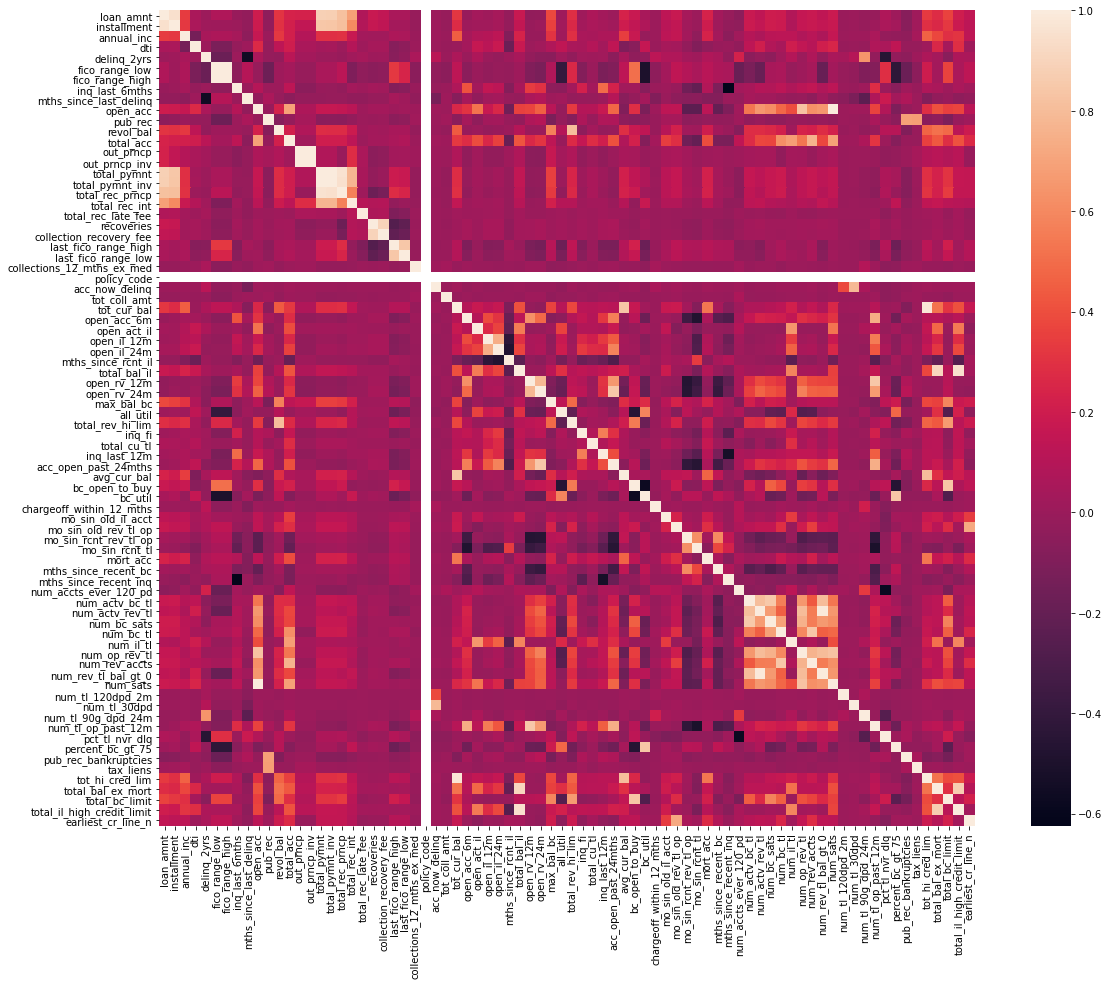

In [0]:
cor = df.corr() 
plt.subplots(figsize=(20,15))
sns.heatmap(cor, square = True)

From the above heatmap we can observe that there is a high correlation between quite a few variables. For example: 
1. fico_range_high and fico_range_low
2. last_fico_range_high and last_fico_range_low

Therefore, instead of keeping both. I am taking average of such values to eliminate one columns and reduce multicollinearity. 



In [0]:
# calcualte mean fico score
df['fico_avg'] = (df['fico_range_high'] + df['fico_range_low'])/2
# calcualte mean last_fico score
df['last_fico_avf'] = (df['last_fico_range_high'] + df['last_fico_range_low'])/2
#Dropping the columns that are not transformed to new columns
drop_list8 = ['fico_range_high','last_fico_range_high','last_fico_range_low','last_fico_range_high']
df = df.drop(drop_list8,axis=1)

In [0]:
#Opps. I missed one columns. 
df = df.drop(['fico_range_low'],axis=1)

In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,NaN,3.0,0.0,13648,83.70%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.0,863.16,0.0,0.0,0.0,Jan-15,May-19,0.0,1,Individual,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013,737.0,712.0


#Seeing next 5 columns:

- inq_last_6mths:
The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

- mths_since_last_delinq: 
The number of months since the borrower's last delinquency.

- open_acc:
The number of open credit lines in the borrower’s credit file.

- pub_rec: Number of derogatory public records

- revol_bal : Total credit revolving balance





In [0]:
#df['mths_since_last_delinq'].unique()
df['mths_since_last_delinq'].count()
print(100*df['mths_since_last_delinq'].isna().sum()/len(df))

54.52997947717659


In [0]:
df['mths_since_last_delinq'].describe()

count    151989.000000
mean         34.494523
std          21.782080
min           0.000000
25%          16.000000
50%          31.000000
75%          49.000000
max         195.000000
Name: mths_since_last_delinq, dtype: float64

I can either drop this column or impute ~45% missing values. But, with what? Let's visualize this first to see if I can understand that. As of now , I am confused with this attribute.

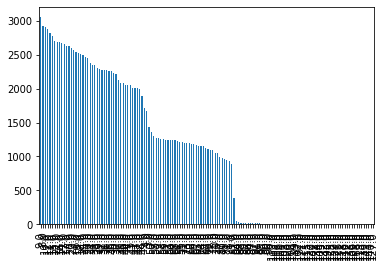

In [0]:
df['mths_since_last_delinq'].value_counts().plot.bar()
plt.show()

In [0]:
#I still can't decide. I wanted to impute '0' as most of the values are 0
df.drop(['mths_since_last_delinq'],axis=1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,3.0,0.0,13648,83.70%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.0000,Jan-15,May-19,0.0,1,Individual,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013,737.0,712.0
1,2500,60 months,59.83,< 1 year,RENT,30000.0,Source Verified,Charged Off,n,Borrower added on 12/22/11 > I plan to use t...,GA,0.000100,0.0,5.0,3.0,0.0,1687,9.40%,4.0,f,0.00,0.00,1014.530000,1014.53,456.46,435.17,0.00,122.90,1.1100,Apr-13,Oct-16,0.0,1,Individual,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,major_purchases,21.075975,742.0,249.5
2,2400,36 months,84.33,10+ years,RENT,12252.0,Not Verified,Fully Paid,n,NaN,IL,0.000872,0.0,2.0,2.0,0.0,2956,98.50%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.0000,Jun-14,Jun-17,0.0,1,Individual,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,life_events,18.488706,737.0,737.0
3,10000,36 months,339.31,10+ years,RENT,49200.0,Source Verified,Fully Paid,n,Borrower added on 12/21/11 > to pay for prop...,CA,0.002000,0.0,1.0,10.0,0.0,5598,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.0000,Jan-15,Apr-16,0.0,1,Individual,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,other,24.238193,692.0,602.0
4,3000,60 months,67.79,1 year,RENT,80000.0,Source Verified,Fully Paid,n,Borrower added on 12/21/11 > I plan on combi...,OR,0.001794,0.0,0.0,15.0,0.0,27783,53.90%,38.0,f,0.00,0.00,4066.908161,4066.91,3000.00,1066.91,0.00,0.00,0.0000,Jan-17,Apr-18,0.0,1,Individual,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,other,24.323066,697.0,682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334257,24000,60 months,543.50,7 years,MORTGAGE,95000.0,Source Verified,Fully Paid,n,NaN,AL,0.001961,0.0,0.0,5.0,0.0,49431,84.40%,54.0,f,0.00,0.00,30444.213690,30444.21,24000.00,6444.21,0.00,0.00,0.0000,May-19,May-19,0.0,1,Individual,0.0,0

In [0]:
df['open_acc'].head()

0     3.0
1     3.0
2     2.0
3    10.0
4    15.0
Name: open_acc, dtype: float64

Can't be very sure. But, by definition, all of these seems important. So, for now, I am letting them be. 

Let's proceed and contninue to improve financial jargon vocabulary. 

- revol_util	- 
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit. In simpler terms, the credit card debt to limit ratio as a percentage. (seems important) (however, need further clearning)

- total_acc - The total number of credit lines currently in the borrower’s credit file (seems important)

- initial_list_status - The initial listing status of the loan. Possible values are – W, F (not able to find what W, F means) (Not sure) (need to see separately)

- out_prncp	: Remaining outstanding principal for total amount funded

- out_prncp_inv	: Remaining outstanding principal for portion of total amount funded by investors

- total_pymnt	: Payments received to date for total amount funded

- total_pymnt_inv	: Payments received to date for portion of total amount funded by investors

- total_rec_prncp	: Principal received to date

- total_rec_int	: Interest received to date

- total_rec_late_fee	: Late fees received to date

- recoveries	: post charge off gross recovery

- collection_recovery_fee	: post charge off collection fee

- last_pymnt_d : Last month payment was received

We need to drop the following columns as they contain information that will not be present while applying for a loan. Meaning, all of them contains data from the future which will not be present at the initial state for the unseen data (people applying for loan)

- out_prncp
- out_prncp_inv
- total_pymnt
- total_pymnt_inv
- total_rec_prncp
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt
- last_credit_pull_d




In [0]:
drop_list9 = ['out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int',
        'total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d',
        'last_credit_pull_d']
df = df.drop(drop_list9,axis=1)

In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,...,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,NaN,3.0,0.0,13648,83.70%,9.0,f,0.0,1,Individual,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013,737.0,712.0


- initial_list_status	: The initial listing status of the loan. Possible values are – W, F (not sure what W, F means)
- collections_12_mths_ex_med	: Number of collections in 12 months excluding medical collections (need to see further)
- policy_code	: publicly available policy_code=1\nnew products not publicly available policy_code=2
- application_type	: Indicates whether the loan is an individual application or a joint application with two co-borrowers
- acc_now_delinq : The number of accounts on which the borrower is now delinquent.


In [0]:
df['initial_list_status'].head()
df['initial_list_status'].unique()
df['initial_list_status'].count()

334262

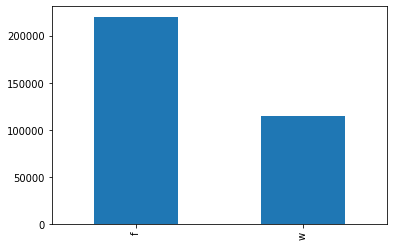

In [0]:
df['initial_list_status'].value_counts().plot.bar()
plt.show()

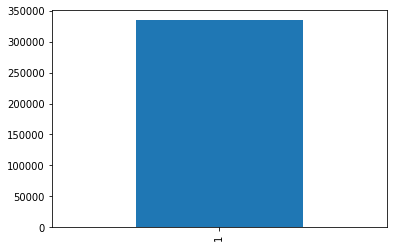

In [0]:
df['policy_code'].value_counts().plot.bar()
plt.show()

In [0]:
print(df.policy_code.value_counts())
print(df.initial_list_status.value_counts())

1    334262
Name: policy_code, dtype: int64
f    220101
w    114161
Name: initial_list_status, dtype: int64


The columns 'policy_code' has only one class and do not provide any information that would be useful in building a predictive model and not able to understand what W, F means in Initial listing status. Removing them.!

In [0]:
drop_list10 =['policy_code', 'initial_list_status']
df = df.drop(drop_list10,axis=1)

In [0]:
df['collections_12_mths_ex_med'].value_counts()

0.0    331494
1.0      2449
2.0       147
3.0        13
4.0         6
5.0         4
7.0         1
6.0         1
8.0         1
9.0         1
Name: collections_12_mths_ex_med, dtype: int64

'collections_12_mths_ex_med' has almost all values as 0 and will therefore not be very useful for modeling. Removing it.

In [0]:
df = df.drop(['collections_12_mths_ex_med'],axis=1)

In [0]:
df['application_type'].value_counts()

Individual    330126
Joint App       4136
Name: application_type, dtype: int64

Dropping application type as it has very few data points for joint application

In [0]:
df = df.drop(['application_type'],axis=1)

In [0]:
df['acc_now_delinq'].value_counts()

0.0    333138
1.0      1032
2.0        51
3.0         6
4.0         3
5.0         2
6.0         1
Name: acc_now_delinq, dtype: int64

In [0]:
df['acc_now_delinq'].isna().sum()

29

In [0]:
#Not many missing values and majority of the class contains 0. So, imputing with 0.
df['acc_now_delinq'] = df['acc_now_delinq'].fillna(0)

In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,NaN,3.0,0.0,13648,83.70%,9.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013,737.0,712.0


- tot_coll_amt	: Total collection amounts ever owed (Seems important as how much was owed can definitely tell if a person is likely to default or not)
- tot_cur_bal	: Total current balance of all accounts (how much a person keeps in his account surely can be a predictor to tell if he will default or not) (Trust me on this, I have and obviously, I am close to nil almost all the time)

Below 4 are more or less related to open_acc (The number of open credit lines in the borrower's credit file).Therefore, removing them. 
- open_acc_6m :	Number of open trades in last 6 months
- open_il_12m	: Number of installment accounts opened in past 12 months
- open_il_24m	: Number of installment accounts opened in past 24 months
- open_act_il	: Number of currently active installment trades

In [0]:
drop_list11 = ['open_acc_6m','open_il_12m','open_il_24m','open_act_il']
df = df.drop(drop_list11,axis=1)

In [0]:
print(df['tot_coll_amt'].value_counts())
print(df['tot_coll_amt'].describe())
print(df['tot_cur_bal'].value_counts())
print(df['tot_cur_bal'].describe())
#As majority of the class contains 0. So, imputing with 0.
df['tot_coll_amt'] = df['tot_coll_amt'].fillna(0)
df['tot_cur_bal'] = df['tot_cur_bal'].fillna(0)

0.0        231490
50.0          498
100.0         390
75.0          319
60.0          223
            ...  
5151.0          1
12638.0         1
10809.0         1
1912.0          1
4095.0          1
Name: tot_coll_amt, Length: 5010, dtype: int64
count    263986.000000
mean        154.674051
std        2162.366510
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      848438.000000
Name: tot_coll_amt, dtype: float64
0.0          44
22396.0      13
13721.0      11
19830.0      11
14163.0      11
             ..
3254633.0     1
50854.0       1
406833.0      1
406839.0      1
379567.0      1
Name: tot_cur_bal, Length: 170518, dtype: int64
count    2.639860e+05
mean     1.402929e+05
std      1.563619e+05
min      0.000000e+00
25%      2.842000e+04
50%      8.097800e+04
75%      2.107005e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64


In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_bal_il,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,NaN,3.0,0.0,13648,83.70%,9.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013,737.0,712.0


- mths_since_rcnt_il	: Months since most recent installment accounts opened
- total_bal_il :Total current balance of all installment accounts	 
- open_rv_12m	: Number of revolving trades opened in past 12 months
- open_rv_24m :	Number of revolving trades opened in past 24 months
- max_bal_bc : Maximum current balance owed on all revolving accounts	
- all_util : Balance to credit limit on all trades	
- total_rev_hi_lim : Total revolving high credit/credit limit	
- inq_fi : Number of personal finance inquiries	
- total_cu_tl : Number of finance trades

In [0]:
df['mths_since_rcnt_il'].head()
print(df['mths_since_rcnt_il'].describe())
print(df['mths_since_rcnt_il'].value_counts())

count    100908.000000
mean         20.348823
std          25.367984
min           0.000000
25%           7.000000
50%          13.000000
75%          22.000000
max         511.000000
Name: mths_since_rcnt_il, dtype: float64
13.0     5127
3.0      4997
4.0      4728
14.0     4320
7.0      4297
         ... 
283.0       1
407.0       1
205.0       1
411.0       1
511.0       1
Name: mths_since_rcnt_il, Length: 261, dtype: int64


In [0]:
def check_stats(col):
  print(df[col].head())
  print(df[col].describe())
  print(df[col].value_counts())

In [0]:
check_stats('open_rv_12m')

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: open_rv_12m, dtype: float64
count    103546.000000
mean          1.343992
std           1.524992
min           0.000000
25%           0.000000
50%           1.000000
75%           2.000000
max          26.000000
Name: open_rv_12m, dtype: float64
0.0     35939
1.0     31378
2.0     18379
3.0      9256
4.0      4360
5.0      2132
6.0      1025
7.0       489
8.0       251
9.0       132
10.0       76
11.0       56
12.0       30
15.0       11
13.0       11
14.0        7
16.0        6
17.0        3
20.0        2
18.0        1
19.0        1
26.0        1
Name: open_rv_12m, dtype: int64


In [0]:
check_stats('max_bal_bc')

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: max_bal_bc, dtype: float64
count    103546.000000
mean       5716.711829
std        5296.596961
min           0.000000
25%        2375.000000
50%        4383.000000
75%        7354.000000
max      226839.000000
Name: max_bal_bc, dtype: float64
0.0        2244
3000.0       42
2000.0       37
5000.0       35
4000.0       31
           ... 
13955.0       1
13951.0       1
20759.0       1
16524.0       1
23901.0       1
Name: max_bal_bc, Length: 18687, dtype: int64


In [0]:
#most of the people has max bal of 0. Therefore, imputing with same:
df["max_bal_bc"] = df["max_bal_bc"].fillna(0)

In [0]:
#Imputing with Median.
#df['open_rv_12m'] = df['open_rv_12m'].fillna(0)
df["open_rv_12m"] = df["open_rv_12m"].transform(lambda x: x.fillna(x.median()))

In [0]:
#For simplification, keeping only 'open_rv_12' and therefore, removing 'open_rv_24m'
df = df.drop(['open_rv_24m'],axis=1)

In [0]:
check_stats('all_util')

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: all_util, dtype: float64
count    103540.000000
mean         59.833320
std          20.221068
min           0.000000
25%          46.000000
50%          61.000000
75%          74.000000
max         172.000000
Name: all_util, dtype: float64
65.0     2090
59.0     2068
61.0     2044
63.0     2034
64.0     2021
         ... 
162.0       1
145.0       1
172.0       1
144.0       1
171.0       1
Name: all_util, Length: 152, dtype: int64


In [0]:
#Imputing with Median as the data is skewed to left.
df["all_util"] = df["all_util"].transform(lambda x: x.fillna(x.median()))

In [0]:
check_stats('total_rev_hi_lim')

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: total_rev_hi_lim, dtype: float64
count    2.639860e+05
mean     3.127535e+04
std      3.642529e+04
min      0.000000e+00
25%      1.400000e+04
50%      2.350000e+04
75%      3.870850e+04
max      9.999999e+06
Name: total_rev_hi_lim, dtype: float64
15000.0     886
14500.0     885
9000.0      882
11500.0     868
10000.0     864
           ... 
25564.0       1
204500.0      1
25562.0       1
30856.0       1
46946.0       1
Name: total_rev_hi_lim, Length: 13784, dtype: int64


In [0]:
#Imputing with Median as the data is skewed to left.
df["total_rev_hi_lim"] = df["total_rev_hi_lim"].transform(lambda x: x.fillna(x.median()))

In [0]:
check_stats('inq_fi')

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: inq_fi, dtype: float64
count    103546.000000
mean          0.951876
std           1.495082
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          48.000000
Name: inq_fi, dtype: float64
0.0     55531
1.0     24075
2.0     11925
3.0      5645
4.0      2909
5.0      1535
6.0       831
7.0       471
8.0       244
9.0       152
10.0       75
11.0       48
12.0       35
13.0       23
14.0       12
15.0       11
16.0        9
17.0        7
22.0        2
19.0        2
25.0        1
48.0        1
20.0        1
21.0        1
Name: inq_fi, dtype: int64


In [0]:
#most of the people do not have personal finance inquiries. Therefore, imputing with same:
df["inq_fi"] = df["inq_fi"].fillna(0)

In [0]:
check_stats('total_cu_tl')
#Trade finance signifies financing for trade, and it concerns both domestic and international trade transactions. 
#A trade transaction requires a seller of goods and services as well as a buyer. 
#Various intermediaries such as banks and financial institutions can facilitate these transactions by financing the trade. 
#Trade finance manifest itself in the form of letters of credit (LOC), guarantees or insurance and is usually provided by intermediaries.

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: total_cu_tl, dtype: float64
count    103546.000000
mean          1.456599
std           2.644916
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max          44.000000
Name: total_cu_tl, dtype: float64
0.0     56384
1.0     17457
2.0      9474
3.0      6008
4.0      4059
5.0      2714
6.0      2014
7.0      1428
8.0      1065
9.0       770
10.0      543
11.0      400
12.0      293
13.0      219
14.0      169
15.0      116
16.0       84
17.0       73
18.0       53
19.0       41
22.0       34
20.0       33
21.0       21
23.0       18
24.0       16
26.0       14
25.0       11
30.0        9
28.0        3
31.0        3
27.0        3
33.0        3
40.0        2
32.0        2
35.0        2
41.0        2
39.0        1
37.0        1
42.0        1
43.0        1
44.0        1
29.0        1
Name: total_cu_tl, dtype: int64


In [0]:
#most of the people do not have finance trades. Therefore, imputing with same:
df["total_cu_tl"] = df["total_cu_tl"].fillna(0)

In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,NaN,3.0,0.0,13648,83.70%,9.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,61.0,23500.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013,737.0,712.0


- inq_last_12m : Number of credit inquiries in past 12 months (similar to inq_fi, therefore, removing)
- chargeoff_within_12_mths : Number of charge-offs within 12 months	

By definition, removign following as they don't seem much relevant for predictive modelling. 

- acc_open_past_24mths : Number of trades opened in past 24 months.
- avg_cur_bal	: Average current balance of all accounts
- bc_open_to_buy :	Total open to buy on revolving bankcards.
- bc_util	: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
- mo_sin_old_il_acct	: Months since oldest bank installment account opened
- mo_sin_old_rev_tl_op : Months since oldest revolving account opened	
- mo_sin_rcnt_rev_tl_op	: Months since most recent revolving account opened
- mo_sin_rcnt_tl : Months since most recent account opened


In [0]:
drop_list12 = ['inq_last_12m','acc_open_past_24mths','avg_cur_bal','bc_open_to_buy','bc_util','mo_sin_old_il_acct','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl']
df = df.drop(drop_list12,axis=1)

In [0]:
check_stats('chargeoff_within_12_mths')

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: chargeoff_within_12_mths, dtype: float64
count    334117.000000
mean          0.005612
std           0.085710
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           7.000000
Name: chargeoff_within_12_mths, dtype: float64
0.0    332456
1.0      1496
2.0       135
3.0        20
5.0         4
4.0         4
7.0         1
6.0         1
Name: chargeoff_within_12_mths, dtype: int64


The column labeled 'chargeoff_within_12_mths' have almost all values as 0 and will therefore not be very useful for modeling. Removing it.

In [0]:
df = df.drop(['chargeoff_within_12_mths'],axis=1)

In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,NaN,3.0,0.0,13648,83.70%,9.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,61.0,23500.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013,737.0,712.0


- mort_acc : Number of mortgage accounts.
- mths_since_recent_bc	: Months since most recent bankcard account opened.
- mths_since_recent_inq	: Months since most recent inquiry.
- num_accts_ever_120_pd	: Number of accounts ever 120 or more days past due
- num_actv_bc_tl : Number of currently active bankcard accounts
- num_actv_rev_tl	: Number of currently active revolving trades
- num_bc_sats	: Number of satisfactory bankcard accounts
- num_bc_tl	: Number of bankcard accounts
- num_il_tl	: Number of installment accounts
- num_op_rev_tl	: Number of open revolving accounts
- num_rev_accts	: Number of revolving accounts
- num_rev_tl_bal_gt_0	: Number of revolving trades with balance >0
- num_sats	: Number of satisfactory accounts
- num_tl_120dpd_2m	: Number of accounts currently 120 days past due (updated in past 2 months)
- num_tl_30dpd	: Number of accounts currently 30 days past due (updated in past 2 months)
- num_tl_90g_dpd_24m	: Number of accounts 90 or more days past due in last 24 months
- num_tl_op_past_12m : Number of accounts opened in past 12 months

In [0]:
new_list_to_check = ['mort_acc',	'mths_since_recent_bc',	'mths_since_recent_inq',	'num_accts_ever_120_pd',	'num_actv_bc_tl',	'num_actv_rev_tl',	'num_bc_sats',	'num_bc_tl',	'num_il_tl',	'num_op_rev_tl',	'num_rev_accts',	'num_rev_tl_bal_gt_0',	'num_sats',	'num_tl_120dpd_2m',	'num_tl_30dpd',	'num_tl_90g_dpd_24m',	'num_tl_op_past_12m']
for col in new_list_to_check:
  print(check_stats(col))

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: mort_acc, dtype: float64
count    284232.000000
mean          1.698197
std           2.067894
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          61.000000
Name: mort_acc, dtype: float64
0.0     115787
1.0      49665
2.0      39534
3.0      29132
4.0      20373
5.0      13070
6.0       7690
7.0       4233
8.0       2222
9.0       1193
10.0       600
11.0       312
12.0       148
13.0        97
14.0        63
15.0        35
16.0        20
17.0        12
18.0        11
19.0        10
23.0         5
24.0         5
20.0         4
22.0         3
27.0         2
29.0         1
30.0         1
31.0         1
28.0         1
25.0         1
61.0         1
Name: mort_acc, dtype: int64
None
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: mths_since_recent_bc, dtype: float64
count    281632.000000
mean         25.205009
std          30.824454
min           0.000000
25%           6.000000
50%          14.0

In [0]:
#df["mort_acc"] = df["mort_acc"].fillna(0)
#df["num_accts_ever_120_pd"] = df["num_accts_ever_120_pd"].fillna(0)
#Too many missing values, mostyly biased to one value and not that relevant of a feature
#drop_list13 = ['mths_since_recent_bc','mths_since_recent_inq','num_actv_bc_tl','num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl','num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','num_tl_120dpd_2m']
#df = df.drop(drop_list13,axis=1)

In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,mort_acc,num_accts_ever_120_pd,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,NaN,3.0,0.0,13648,83.70%,9.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,61.0,23500.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N,N,debt,35.321013,737.0,712.0


Exploring Next 10 columns:
- pct_tl_nvr_dlq	: Percent of trades never delinquent

- percent_bc_gt_75	: Percentage of all bankcard accounts > 75% of limit.

- pub_rec_bankruptcies	: Number of public record bankruptcies (seems like important attribute)

- tax_liens	: Number of tax liens

- tot_hi_cred_lim	: Total high credit/credit limit

- total_bal_ex_mort	: Total credit balance excluding mortgage

- total_bc_limit	: Total bankcard high credit/credit limit

- total_il_high_credit_limit	: Total installment high credit/credit limit

- hardship_flag	: Flags whether or not the borrower is on a hardship plan

- debt_settlement_flag : Flags whether or not the borrower, who has charged-off, is working with a debt-settlement company.

In [0]:
list_next_10_till_debt_settlement = ['pct_tl_nvr_dlq','percent_bc_gt_75',	'pub_rec_bankruptcies',	'tax_liens',	'tot_hi_cred_lim',	'total_bal_ex_mort',	'total_bc_limit',	'total_il_high_credit_limit','hardship_flag',	'debt_settlement_flag']

In [0]:
for col in list_next_10_till_debt_settlement:
  print(check_stats(col))

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: pct_tl_nvr_dlq, dtype: float64
count    263833.000000
mean         94.574750
std           8.404424
min           0.000000
25%          92.000000
50%         100.000000
75%         100.000000
max         100.000000
Name: pct_tl_nvr_dlq, dtype: float64
100.0    136624
96.0       7957
95.0       7876
90.0       5490
97.0       5359
          ...  
18.0          1
15.0          1
54.1          1
74.6          1
31.6          1
Name: pct_tl_nvr_dlq, Length: 508, dtype: int64
None
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: percent_bc_gt_75, dtype: float64
count    281351.000000
mean         49.559745
std          35.394278
min           0.000000
25%          20.000000
50%          50.000000
75%          80.000000
max         100.000000
Name: percent_bc_gt_75, dtype: float64
100.00    56270
0.00      54589
50.00     32987
66.70     21517
33.30     19084
          ...  
73.70         1
0.29          1
42.40         1
20.80         1
3.80       

In [0]:
# majority of the trades never delinquent (can been seen from mean). Therefore, removing pct_tl_nvr_dlq.
# Most of the values are missing and not that relevant of a feature. Therefore, removing percent_bc_gt_75.
drop_list14 = ['pct_tl_nvr_dlq','percent_bc_gt_75','tot_hi_cred_lim','total_bal_ex_mort','total_bc_limit','total_il_high_credit_limit','hardship_flag','debt_settlement_flag']
df.drop(drop_list14, axis=1, inplace=True) 

In [0]:
# The column labeled 'tax_liens' have almost all values as 0 and will therefore not be very useful for modeling. Removing it.
df =df.drop(['tax_liens'],axis=1)

In [0]:
df.head(1)

,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,pymnt_plan,desc,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,mths_since_rcnt_il,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,mort_acc,num_accts_ever_120_pd,pub_rec_bankruptcies,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf
0,5000,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,n,Borrower added on 12/22/11 > I need to upgra...,AZ,0.002765,0.0,1.0,NaN,3.0,0.0,13648,83.70%,9.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,61.0,23500.0,0.0,0.0,0.0,0.0,0.0,debt,35.321013,737.0,712.0


In [0]:
df.to_csv('lending_club.csv')
!cp lending_club.csv "drive/My Drive/"

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334262 entries, 0 to 334261
Data columns (total 38 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   loan_amnt               334262 non-null  int64  
 1   term                    334262 non-null  object 
 2   installment             334262 non-null  float64
 3   emp_length              318386 non-null  object 
 4   home_ownership          334262 non-null  object 
 5   annual_inc              334258 non-null  float64
 6   verification_status     334262 non-null  object 
 7   loan_status             334262 non-null  object 
 8   pymnt_plan              334262 non-null  object 
 9   desc                    110721 non-null  object 
 10  addr_state              334262 non-null  object 
 11  dti                     334234 non-null  float64
 12  delinq_2yrs             334233 non-null  float64
 13  inq_last_6mths          334233 non-null  float64
 14  mths_since_last_deli

In [0]:
# Copy Dataframe
#complete_df = df.copy()

In [0]:
#Months since most recent installment accounts opened. 
#I don't deem it much relevant for predictive modeling. Therefore, removing.
complete_df = complete_df.drop(['mths_since_rcnt_il'],axis=1)

In [0]:
# Missing values statistics
miss_values = null_values(complete_df)
miss_values.head(20)

Dataframe has 37 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
total_bal_il,230716,69.0
desc,223541,66.9
mths_since_last_delinq,182273,54.5
emp_length,15876,4.7
pub_rec_bankruptcies,1365,0.4
revol_util,298,0.1
delinq_2yrs,29,0.0
inq_last_6mths,29,0.0
open_acc,29,0.0
pub_rec,29,0.0


#With this, I am done with data cleaning. FINALLY!

I’ve been able to reduce the number of columns from 150 to 37 without losing any meaningful data for our model. 

Data Cleaning Summary: 
- Dropped Data that must have been captured after the application form. This would have messed up our model. 

- Imputed missing values with either 0 or median

- Created new feature out of existing (taking average of FICO_low and FICO_high)





"Our goal here is to predict whether a person will be able to pay off a loan or  he/she will default.
We can see from data dictionary that loan_status is the only field that describes a loan status.

Therefore, we will be using it as target column."



In [0]:
complete_df['loan_status'].value_counts()

Fully Paid                                             242054
Charged Off                                             50440
Current                                                 36945
Does not meet the credit policy. Status:Fully Paid       1988
Late (31-120 days)                                       1206
Does not meet the credit policy. Status:Charged Off       761
In Grace Period                                           486
Late (16-30 days)                                         295
Default                                                    87
Name: loan_status, dtype: int64

In [0]:
type(complete_df['loan_status'][0])

str

In [0]:
#Currently, this column contains text values that need to be converted to numerical values to be eligible for training a model. 
#Dependent Variable =  Loan_Status 

#Charged Off = 1
#Default = 1
#Late (31-120 days) = 1
#Does not meet credit policy. Status Charged Off = 1

#Current = 0
#Fully Paid = 0
#In Grace Period = 0
#Late (16-30 days) = 0
#Does not meet credit policy. Status Fully Paid = 0

In [0]:
complete_df['loan_status'] = complete_df['loan_status'].replace("Charged Off", "Default")

In [0]:
complete_df['loan_status'] = complete_df['loan_status'].replace("Late (31-120 days)", "Default")

In [0]:
complete_df['loan_status'] = complete_df['loan_status'].replace("Does not meet credit policy. Status Charged Off", "Default")

In [0]:
target_list = [1 if i=='Default' else 0 for i in complete_df['loan_status']]

complete_df['TARGET'] = target_list
complete_df['TARGET'].value_counts()

0    282529
1     51733
Name: TARGET, dtype: int64

Visualizing the Target Column Outcomes

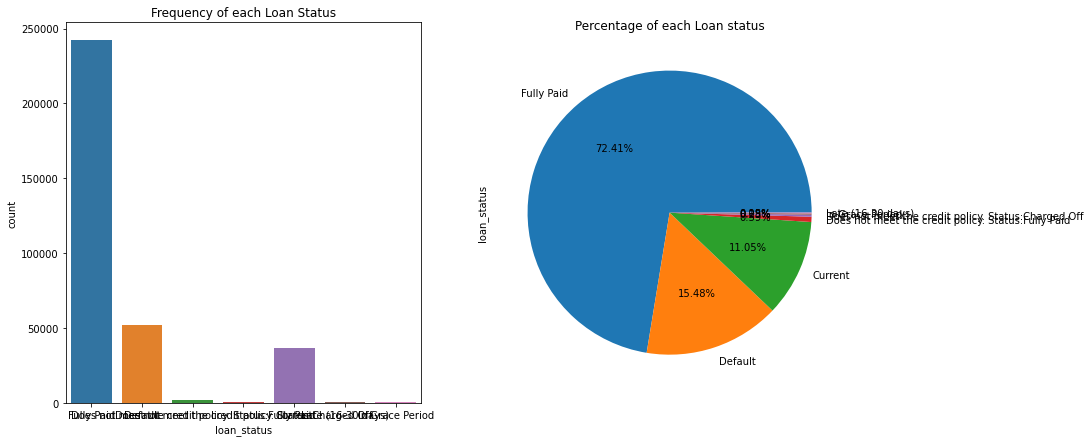

In [0]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=complete_df,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
complete_df.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

We can see from the target plot above that we are dealing with an imbalanced dataset. This means one result type is dominating the other one(s). In this case, we have a lot of "fully paid" records but not many records of other 6 records. However, we will now make the records binary and then see this plot again.

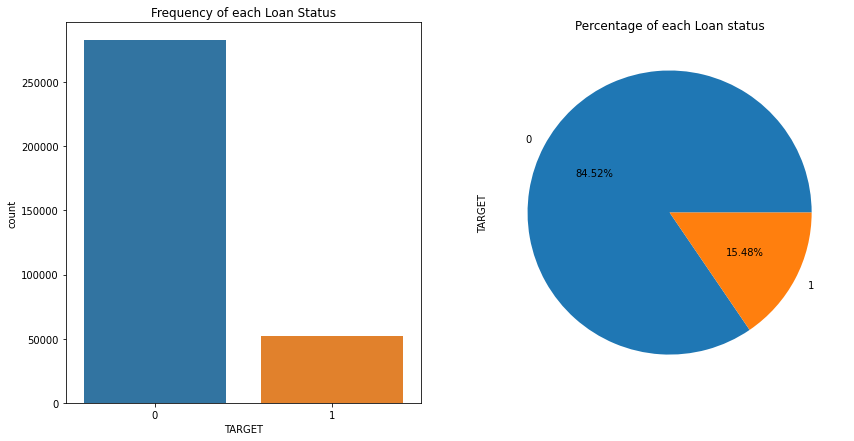

In [0]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='TARGET',data=complete_df,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
complete_df.TARGET.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

In [0]:
complete_df.drop('loan_status',axis=1,inplace=True)

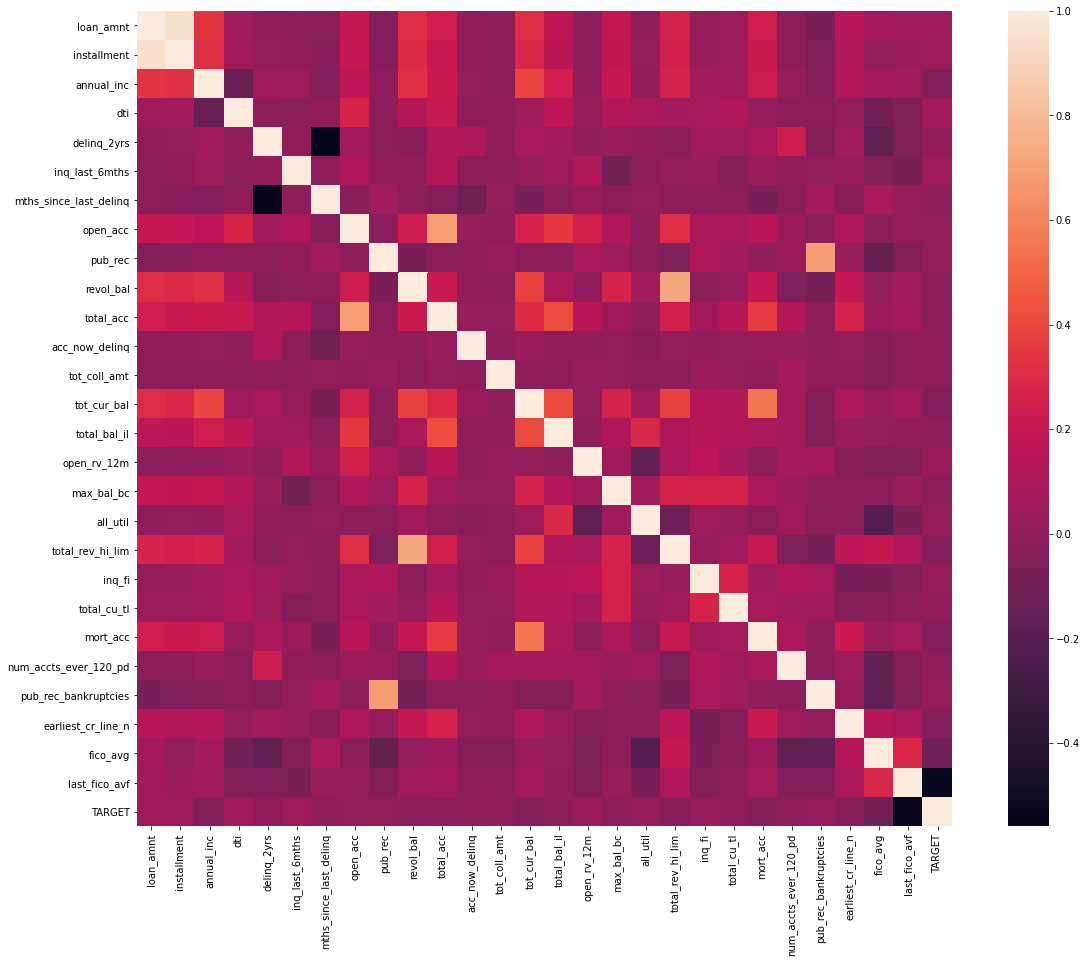

In [0]:
import seaborn as sns
from matplotlib import pyplot as plt
cor = complete_df.corr() 
plt.subplots(figsize=(20,15))
sns.heatmap(cor, square = True)

In [0]:
complete_df['emp_length'].head(3)

0    10+ years
1     < 1 year
2    10+ years
Name: emp_length, dtype: object

I'll be filling the null values with 0 assuming that the borrower hasn't worked many years for his data to be recorded. Also, I'll be using regex to extract the number of years from all of the data.

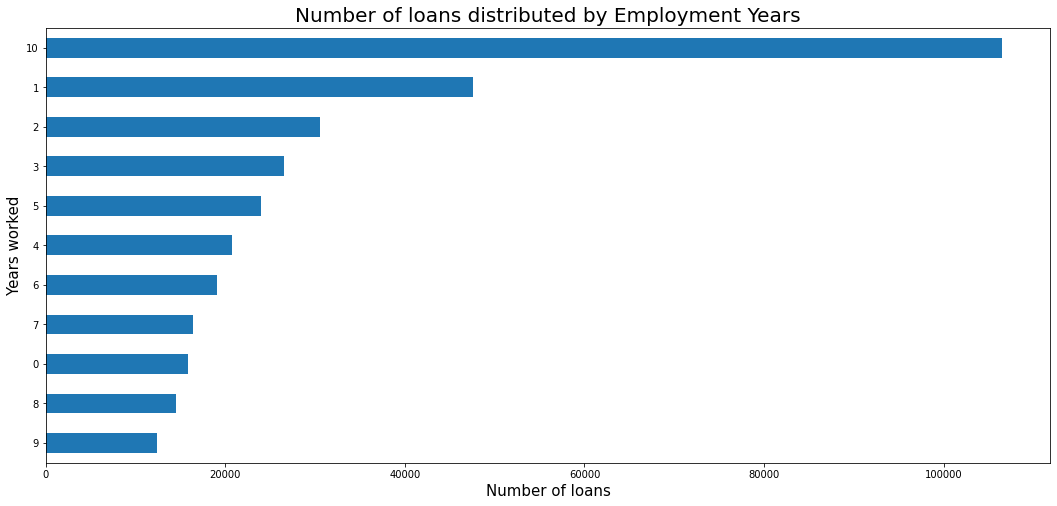

In [0]:
complete_df['emp_length'].fillna(value=0,inplace=True)

complete_df['emp_length'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)

complete_df['emp_length'].value_counts().sort_values().plot(kind='barh',figsize=(18,8))
plt.title('Number of loans distributed by Employment Years',fontsize=20)
plt.xlabel('Number of loans',fontsize=15)
plt.ylabel('Years worked',fontsize=15);

The column looks fine. Also, it can be seen that people who have worked for 10 or more years are more likely to take a loan.

In [0]:
complete_df['addr_state'].unique()

array(['AZ', 'GA', 'IL', 'CA', 'OR', 'NC', 'TX', 'VA', 'MO', 'CT', 'UT',
       'FL', 'NY', 'PA', 'MN', 'NJ', 'KY', 'OH', 'SC', 'RI', 'LA', 'MA',
       'WA', 'WI', 'AL', 'CO', 'KS', 'NV', 'AK', 'MD', 'WV', 'VT', 'MI',
       'DC', 'SD', 'NH', 'AR', 'NM', 'MT', 'HI', 'WY', 'OK', 'DE', 'MS',
       'TN', 'IA', 'NE', 'ID', 'IN', 'ME', 'ND'], dtype=object)

In [0]:
# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

In [0]:
complete_df['region'] = np.nan
def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
complete_df['region'] = complete_df['addr_state'].apply(finding_regions)

In [0]:
df['pymnt_plan'].value_counts()

n    334232
y        30
Name: pymnt_plan, dtype: int64

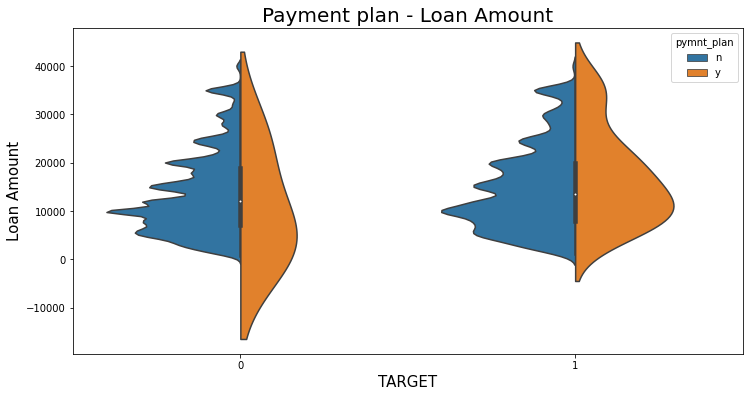

In [0]:
fig = plt.figure(figsize=(12,6))
sns.violinplot(x="TARGET",y="loan_amnt",data=complete_df, hue="pymnt_plan", split=True)
plt.title("Payment plan - Loan Amount", fontsize=20)
plt.xlabel("TARGET", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15);

In [0]:
#The payment plan column (pymnt_plan) has two unique values, 'y' and 'n', with 'y' occurring only 30 times compared to 334232. Let’s drop this column:
#complete_df = complete_df.drop('pymnt_plan', axis=1)

In [0]:
# Missing values statistics
miss_values = null_values(complete_df)
miss_values.head(20)

Dataframe has 37 columns.
There are 13 columns that have missing values.


,Missing Values,% of Total Values
total_bal_il,230716,69.0
desc,223541,66.9
mths_since_last_delinq,182273,54.5
pub_rec_bankruptcies,1365,0.4
revol_util,298,0.1
delinq_2yrs,29,0.0
inq_last_6mths,29,0.0
open_acc,29,0.0
pub_rec,29,0.0
total_acc,29,0.0


In [0]:
check_stats('total_bal_il')
complete_df['total_bal_il'] = complete_df['total_bal_il'].fillna(0)

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: total_bal_il, dtype: float64
count    1.035460e+05
mean     3.657715e+04
std      4.444900e+04
min      0.000000e+00
25%      9.763250e+03
50%      2.403400e+04
75%      4.714500e+04
max      1.044916e+06
Name: total_bal_il, dtype: float64
0.0        10001
4465.0        10
8717.0         9
12738.0        9
15000.0        9
           ...  
49617.0        1
309.0          1
49876.0        1
35568.0        1
65535.0        1
Name: total_bal_il, Length: 57154, dtype: int64


In [0]:
check_stats('mths_since_last_delinq')
#complete_df['total_bal_il'] = complete_df['total_bal_il'].fillna(0)

0     NaN
1     NaN
2     NaN
3    35.0
4    38.0
Name: mths_since_last_delinq, dtype: float64
count    151989.000000
mean         34.494523
std          21.782080
min           0.000000
25%          16.000000
50%          31.000000
75%          49.000000
max         195.000000
Name: mths_since_last_delinq, dtype: float64
9.0      3056
8.0      2922
10.0     2904
12.0     2882
11.0     2822
         ... 
139.0       1
149.0       1
141.0       1
140.0       1
127.0       1
Name: mths_since_last_delinq, Length: 142, dtype: int64


# Dealing with Remaining missing values: Data imputation
 

To deal with missing values in each column, I will do some data imputation dealing with each dtype differently. For dtype = object, I will use the most frequent values while for numerical dtypes, I will use the median

In [0]:
obj_cols = complete_df.columns[complete_df.dtypes==object]

#Imputer function
imputer = lambda x:x.fillna(x.value_counts().index[0]) 

#Impute dtype=object with most frequent value
complete_df[obj_cols] = complete_df[obj_cols].apply(imputer) 

#Impute the rest of df with median
complete_df = complete_df.fillna(df.median(axis=0)) 

In [0]:
# Missing values statistics
miss_values = null_values(complete_df)
miss_values.head(5)

Dataframe has 37 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [0]:
complete_df.to_csv("processed_data/filtered_loans_2007.csv",index=False)


KeyboardInterrupt: ignored

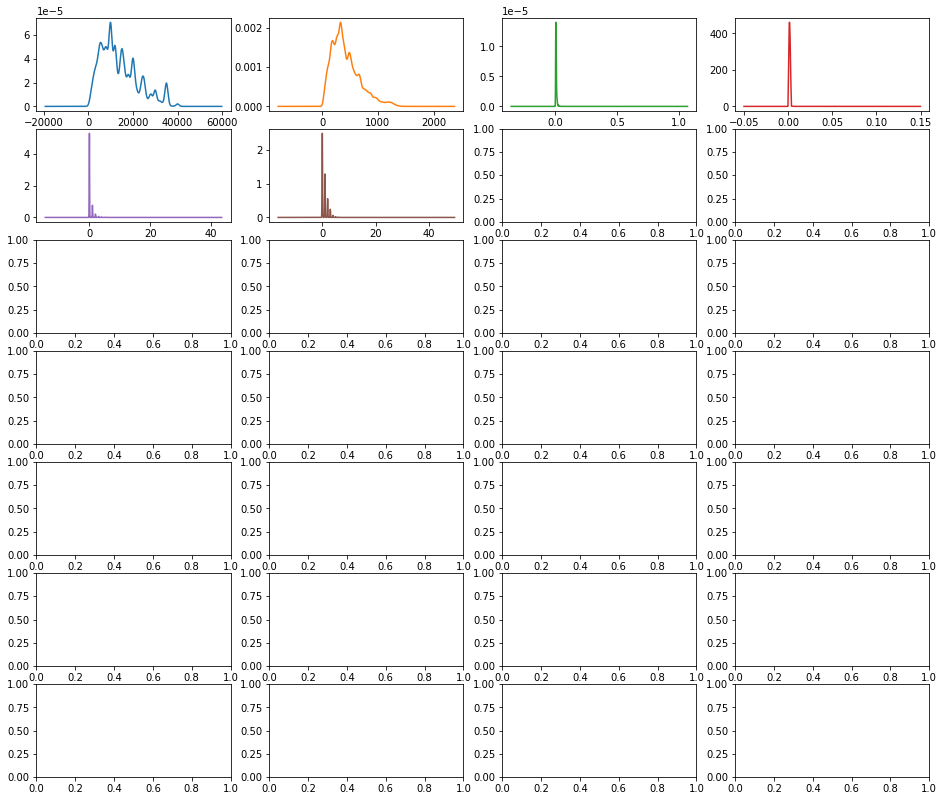

In [0]:
##complete_df.plot(kind='density', subplots=True, layout=(8,4), sharex=False, figsize=(16,16) )
#plt.show()

In [0]:
#complete_df.plot(kind='box', subplots=True, layout=(12,6), sharex=False, sharey=False, figsize=(16,16) )
#plt.show()

In [0]:
complete_df.to_csv('lending_club_cleaned.csv')
!cp lending_club.csv "drive/My Drive/"

In [0]:
#df = pd.get_dummies(df, columns=['emp_length','term', 'home_ownership', 'verification_status'])

In [14]:
import pickle

#complete_df.to_pickle("loan_df.pkl")

#df_filtered = pd.read_pickle("/content/drive/My Drive/lending_club.pkl")

FileNotFoundError: ignored

In [17]:
df_filtered = pd.read_csv("/content/drive/My Drive/lending_club.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [18]:
corr = df_filtered.corr()['TARGET'].sort_values()
# Display correlations
print('Most Positive Correlations:\n', corr.tail(10))
print('\nMost Negative Correlations:\n', corr.head(10))

KeyError: ignored

In [19]:
#From where do most of the loans tend to be defaulted?

fig = plt.figure(figsize=(18,10))
df_filtered[df_filtered['TARGET']==1].groupby('addr_state')['TARGET'].count().sort_values().plot(kind='barh')
plt.ylabel('State',fontsize=15)
plt.xlabel('Number of loans',fontsize=15)
plt.title('Number of defaulted loans per state',fontsize=20);

KeyError: ignored

<Figure size 1296x720 with 0 Axes>

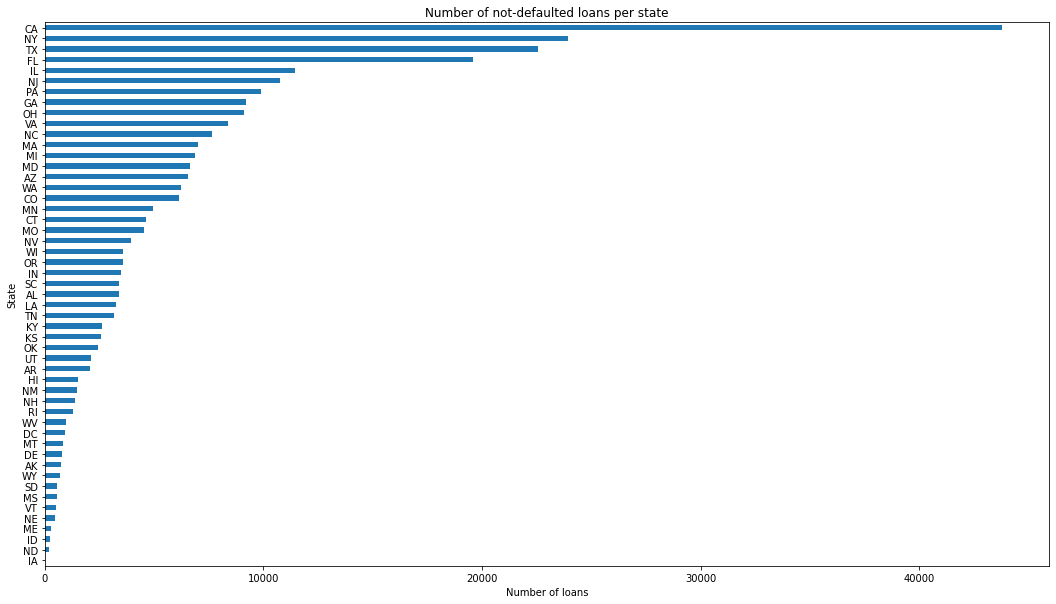

In [0]:
fig = plt.figure(figsize=(18,10))
df_filtered[df_filtered['TARGET']==0].groupby('addr_state')['TARGET'].count().sort_values().plot(kind='barh')
plt.ylabel('State')
plt.xlabel('Number of loans')
plt.title('Number of not-defaulted loans per state');

It can be seen that there are more number of loans taken amount from the same states where there are more number of defaulted risk. This is why the state cannot be taken as a major feature for knowing if a loan will be defaulted or not.



In [0]:
df_filtered.drop(['addr_state'],axis=1,inplace=True)

Here’s an outline of what we’ll be doing in this stage:

- Investigate Categorical Columns
- Convert Categorical Columns To Numeric Features
- Map Ordinal Values To Integers
- Encode Nominal Values As Dummy Variables

In [0]:
print(df_filtered.shape)
df_filtered.head(1)

(334262, 36)


,loan_amnt,term,installment,emp_length,home_ownership,annual_inc,verification_status,desc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_bal_il,open_rv_12m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,mort_acc,num_accts_ever_120_pd,pub_rec_bankruptcies,purpose_n,earliest_cr_line_n,fico_avg,last_fico_avf,TARGET,region
0,5000,36 months,162.87,10,RENT,24000.0,Verified,Borrower added on 12/22/11 > I need to upgra...,0.002765,0.0,1.0,31.0,3.0,0.0,13648,83.70%,9.0,0.0,0.0,0.0,0.0,1.0,0.0,61.0,23500.0,0.0,0.0,0.0,0.0,0.0,debt,35.321013,737.0,712.0,0,SouthWest


In [0]:
null_counts = df_filtered.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
loan_amnt                 0
term                      0
installment               0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
desc                      0
dti                       0
delinq_2yrs               0
inq_last_6mths            0
mths_since_last_delinq    0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util                0
total_acc                 0
acc_now_delinq            0
tot_coll_amt              0
tot_cur_bal               0
total_bal_il              0
open_rv_12m               0
max_bal_bc                0
all_util                  0
total_rev_hi_lim          0
inq_fi                    0
total_cu_tl               0
mort_acc                  0
num_accts_ever_120_pd     0
pub_rec_bankruptcies      0
purpose_n                 0
earliest_cr_line_n        0
fico_avg                  0
last_fico_avf             0
TARGET    

In [0]:
print("Data types and their frequency\n{}".format(df_filtered.dtypes.value_counts()))

Data types and their frequency
float64    25
object      8
int64       3
dtype: int64


We still have 8 object columns that contain text which need to be converted into numeric features. 

Let’s select just the object columns using the DataFrame method select_dtype, then display a sample row to get a better sense of how the values in each column are formatted.

In [0]:
object_columns_df = df_filtered.select_dtypes(include=['object'])
print(object_columns_df.iloc[0])

term                                                           36 months
emp_length                                                            10
home_ownership                                                      RENT
verification_status                                             Verified
desc                     Borrower added on 12/22/11 > I need to upgra...
revol_util                                                        83.70%
purpose_n                                                           debt
region                                                         SouthWest
Name: 0, dtype: object


We see that term, emp_length, revol_util columns contains numeric values, but is formatted as object. 



In [0]:
df_filtered['revol_util'] = df_filtered['revol_util'].str.rstrip('%').astype('float')

Columns with categorical values:

- term — number of payments on the loan, either 36 or 60.
- emp_length — number of years the borrower was employed upon time of application.
- home_ownership — home ownership status, can only be 1 of 4 categorical values according to the data dictionary.
- verification_status — indicates if income was verified by LendingClub.
- desc — 
- purpose_n — a category provided by the borrower for the loan request.
- region - Created column based on states


In [0]:
cols = ['term','emp_length','home_ownership','verification_status', 'purpose_n', 'region']
for name in cols:
    print(name,':')
    print(object_columns_df[name].value_counts(),'\n')

term :
 36 months    254366
 60 months     79896
Name: term, dtype: int64 

emp_length :
10    106549
1      47613
2      30541
3      26575
5      24020
4      20745
6      19079
7      16432
0      15876
8      14495
9      12337
Name: emp_length, dtype: int64 

home_ownership :
MORTGAGE    166740
RENT        136303
OWN          30883
OTHER          182
ANY            104
NONE            50
Name: home_ownership, dtype: int64 

verification_status :
Verified           131804
Not Verified       107818
Source Verified     94640
Name: verification_status, dtype: int64 

purpose_n :
debt               260151
major_purchases     38518
other               20703
life_events         14890
Name: purpose_n, dtype: int64 

region :
West         82028
SouthEast    78689
NorthEast    78534
MidWest      56218
SouthWest    38793
Name: region, dtype: int64 



In [0]:
df_filtered['emp_length'] = df_filtered['emp_length'].astype('int64')

#Convert Categorical Columns to Numeric Features

Ordinal values: these categorical values are in natural order. We can sort or order them either in increasing or decreasing order. 
For example: S < M < L

Nominal Values: these are regular categorical values. We can’t order nominal values. For instance, while we can order loan applicants in the employment length column (emp_length) based on years spent in the workforce:
year 1 < year 2 < year 3 … < year N,

we can’t do that with the column purpose. It wouldn’t make sense to say:

car < wedding < education < moving < house

These are the columns we now have in our dataset:

Ordinal Values
emp_length
Nominal Values _ home_ownership
verification_status
purpose_n
term

In [0]:
#Converting nominal features into numerical features requires encoding them as dummy variables.
nominal_columns = ["home_ownership", "verification_status", "purpose_n", "term"]
dummy_df = pd.get_dummies(complete_df[nominal_columns])
complete_df = pd.concat([complete_df, dummy_df], axis=1)
complete_df = complete_df.drop(nominal_columns, axis=1)

In [0]:
complete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334262 entries, 0 to 334261
Data columns (total 48 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            334262 non-null  int64  
 1   installment                          334262 non-null  float64
 2   emp_length                           334262 non-null  object 
 3   annual_inc                           334262 non-null  float64
 4   desc                                 334262 non-null  object 
 5   addr_state                           334262 non-null  object 
 6   dti                                  334262 non-null  float64
 7   delinq_2yrs                          334262 non-null  float64
 8   inq_last_6mths                       334262 non-null  float64
 9   mths_since_last_delinq               334262 non-null  float64
 10  open_acc                             334262 non-null  float64
 11  pub_rec      

In [2]:
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [6]:
nltk.download("stopwords") 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# Importing the necessary functions
import nltk, re
from nltk.corpus import stopwords
stop = stopwords.words('english')
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
words = set(nltk.corpus.words.words())

# Initialize the lemmatizer
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Let's get a list of stop words from the NLTK library
stop = stopwords.words('english')

snow = SnowballStemmer('english')

def process_text(texts): 
    final_text_list=[]
    for sent in texts:
        filtered_sentence=[]
        
        sent = sent.lower() # Lowercase 
        sent = sent.strip() # Remove leading/trailing whitespace
        sent = re.sub('\s+', ' ', sent) # Remove extra space and tabs
        sent = re.compile('<.*?>').sub('', sent) # Remove HTML tags/markups:
        sent = re.sub(r"\b[A-Z]{2,}\b", "", sent) #removing accronyms
        sent = re.sub(r"\d+","",sent) #removing numbers
        sent = re.sub(r'http\S+', '', sent) #remove URLs

        # Tokenize the sentence
        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if(not w.isnumeric()) and (len(w)>2) and (w not in stop) and (w not in string.punctuation) and (w in words or not w.isalpha()):  
                # Stem and add to filtered list
                filtered_sentence.append(wl.lemmatize(w))
        final_string = " ".join(filtered_sentence) #final string of cleaned words
 
        final_text_list.append(final_string)
    
    return final_text_list

In [9]:
print("Pre-processing the Speech field with use of Lemmatization")
complete_df["desc1"] = process_text(complete_df["desc"].tolist()) 

Pre-processing the Speech field with use of Lemmatization


NameError: ignored

In [0]:
# get length of loan description
def desc_len (x):
    re.sub(".*> |<br>|<br/>", "", x)
    
lc_all['desc1'] = lc_all['desc'].astype(str)
lc_all['desc1'] = lc_all['desc1'].apply(desc_len)
lc_all['desc1'] = lc_all['desc1'].str.len()


In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(df_filtered.drop("TARGET", axis=1), df_filtered['TARGET'], test_size = 0.2,\
random_state=44)

In [0]:
X_test.shape 

(66841, 47)

In [0]:
logit = LogisticRegression()

In [0]:
logit.fit(X_train, Y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
Y_Pred=logit.predict(X_test) 

In [0]:
logit.score(X_test, Y_test)

0.942879370446283

In [0]:
probs = logit.predict_proba(X_test)[::,1]

In [0]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(Y_test, Y_Pred)
cnf_matrix

array([[56036,   446],
       [ 3372,  6987]])

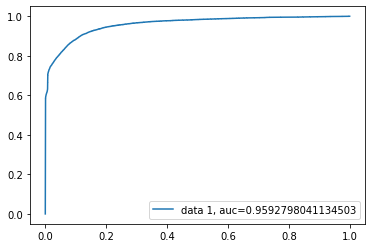

In [0]:
fpr, tpr, _ = metrics.roc_curve(Y_test,  probs)
auc = metrics.roc_auc_score(Y_test, probs)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [0]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_test, probs)
print(auc)

0.9592798041134503


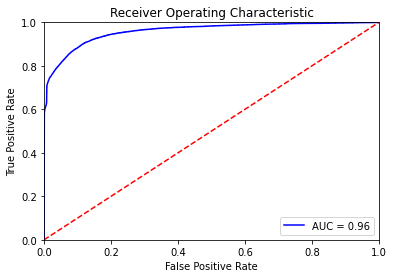

In [0]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, threshold = roc_curve(Y_test, probs)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, f1_score
lrClassifier = LogisticRegression(penalty = 'l2',
                                  C = 0.1,
                                  class_weight = 'balanced')
lrClassifier.fit(X_train, Y_train)
lrClassifier_val_predictions = lrClassifier.predict(X_test)
 
print("LogisticRegression on Validation: Accuracy Score: %f, F1-score: %f" % \
      (accuracy_score(Y_test, lrClassifier_val_predictions), f1_score(Y_test, lrClassifier_val_predictions)))

LogisticRegression on Validation: Accuracy Score: 0.924343, F1-score: 0.770147


Highest Accuracy on Validation: 0.9461707634535689 , Threshold for the highest Accuracy: 0.8


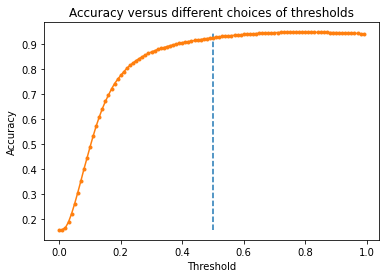

In [0]:
 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
 
# Calculate the accuracy using different values for the classification threshold, 
# and pick the threshold that resulted in the highest accuracy.

highest_accuracy = 0
threshold_highest_accuracy = 0

thresholds = np.arange(0,1,0.01)
scores = []
for t in thresholds:
    # set threshold to 't' instead of 0.5
    y_val_other = (lrClassifier.predict_proba(X_test)[:,1] >= t).astype(float)
    score = accuracy_score(Y_test, y_val_other)
    scores.append(score)
    if(score > highest_accuracy):
        highest_accuracy = score
        threshold_highest_accuracy = t

print("Highest Accuracy on Validation:", highest_accuracy, \
      ", Threshold for the highest Accuracy:", threshold_highest_accuracy)   

# Let's plot the accuracy versus different choices of thresholds

plt.plot([0.5, 0.5], [np.min(scores), np.max(scores)], linestyle='--')
plt.plot(thresholds, scores, marker='.')
plt.title('Accuracy versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

### Threshold calibration to improve model F1 score

Similarly, various choices of classification thresholds would affect the Precision and Recall metrics. Precision and Recall are usually trade offs of each other, so when you can improve both at the same time, your model's overall performance is undeniably improved. To choose a threshold that balances Precision and Recall, we can plot the Precision-Recall curve and pick the point with the highest F1 score.

In [0]:
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
 
# Calculate the precision and recall using different values for the classification threshold
val_predictions_probs = lrClassifier.predict_proba(X_test)
precisions, recalls, thresholds = precision_recall_curve(Y_test, val_predictions_probs[:, 1])

Highest F1 score on Validation: 0.8050692729030179 , Threshold for the highest F1 score: 0.7274559428039931


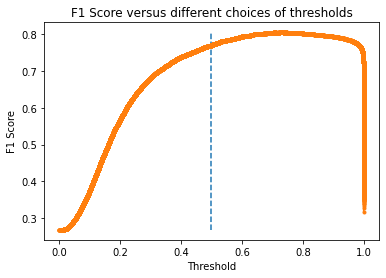

In [0]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
# Calculate the F1 score using different values for the classification threshold, 
# and pick the threshold that resulted in the highest F1 score.
highest_f1 = 0
threshold_highest_f1 = 0
f1_scores = []
for id, threshold in enumerate(thresholds):

    f1_score = 2*precisions[id]*recalls[id]/(precisions[id]+recalls[id])
    f1_scores.append(f1_score)
    if(f1_score > highest_f1):
        highest_f1 = f1_score
        threshold_highest_f1 = threshold
print("Highest F1 score on Validation:", highest_f1, \
      ", Threshold for the highest F1 score:", threshold_highest_f1)
# Let's plot the F1 score versus different choices of thresholds
plt.plot([0.5, 0.5], [np.min(f1_scores), np.max(f1_scores)], linestyle='--')
plt.plot(thresholds, f1_scores, marker='.')
plt.title('F1 Score versus different choices of thresholds')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.show()

In [0]:
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


print("Training data shape:", X_train.shape)
print("Training label shape:", Y_train.shape)

param_grid={'max_depth': [50, 75, 100, 125, 150, 200, 250], 
            'min_samples_leaf': [5, 10, 15, 25, 30],
            'min_samples_split': [2, 5, 15, 25, 30, 45, 50]
           }

# Here, we will use class_weight parameter. This will put more weight to smaller class during training.
dt = DecisionTreeClassifier(class_weight = 'balanced')

grid_search = GridSearchCV(dt, # Base model
                           param_grid, # Parameters to try
                           cv = 5, # Apply 5-fold cross validation
                           verbose = 1, # Print summary
                           n_jobs = -1 # Use all available processors 
                          )

grid_search.fit(X_train, Y_train)

Training data shape: (267364, 47)
Training label shape: (267364,)
Fitting 5 folds for each of 245 candidates, totalling 1225 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 1225 out of 1225 | elapsed: 28.3min finished


CPU times: user 13.5 s, sys: 3.15 s, total: 16.6 s
Wall time: 28min 22s


In [0]:
grid_search.best_params_

{'max_depth': 150, 'min_samples_leaf': 30, 'min_samples_split': 45}

In [0]:
# Let's get the input and output data for testing the classifier

y_pred = grid_search.predict(X_test)

In [0]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(Y_test, y_pred))

[[53753  2729]
 [  786  9573]]


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(Y_test, y_pred))

print("Accuracy:", accuracy_score(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97     56482
           1       0.78      0.92      0.84     10359

    accuracy                           0.95     66841
   macro avg       0.88      0.94      0.91     66841
weighted avg       0.95      0.95      0.95     66841

Accuracy: 0.947412516269954


However, as we are dealing with an imbalanced dataset, accuracy can be a misleading metric. We should make a class based perfomance assessment.


Things to try: 

* Use scaling for numerical fields
* Utilize the text fields to improve our performance (Bag of Words Representation)
* Try target enconding for categorical variables 
* Feature selection: Not all variables may be important, we can achieve higher performance by selecting a subset of our vairables.
* Try ensemble models such as Random Forests

#Decision Tree (Without Hyperparameters)

In [0]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [0]:
probs = clf.predict_proba(X_test)
predicted = clf.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
auc = metrics.roc_auc_score(Y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(Y_test, predicted))
print(metrics.classification_report(Y_test, predicted))


AUC estimate: 0.923
Out-of-bag score estimate: 0.854
Mean accuracy score: 0.958
[[54968  1514]
 [ 1326  9033]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     56482
           1       0.86      0.87      0.86     10359

    accuracy                           0.96     66841
   macro avg       0.92      0.92      0.92     66841
weighted avg       0.96      0.96      0.96     66841



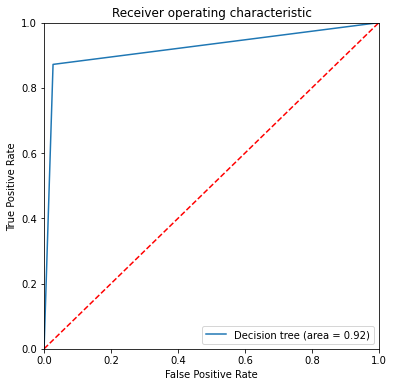

In [0]:
# ROC curve

fpr, tpr, thresholds = roc_curve(Y_test, clf.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Decision tree (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DecisionTree_ROC')
plt.show()


#Neaural Network

In [0]:
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

nn.fit(X_train, Y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(5, 2), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [0]:
probs = nn.predict_proba(X_test)
predicted = nn.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
auc = metrics.roc_auc_score(Y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(Y_test, predicted))
print(metrics.classification_report(Y_test, predicted))


AUC estimate: 0.5
Mean accuracy score: 0.155
[[   10 56472]
 [    2 10357]]
              precision    recall  f1-score   support

           0       0.83      0.00      0.00     56482
           1       0.15      1.00      0.27     10359

    accuracy                           0.16     66841
   macro avg       0.49      0.50      0.13     66841
weighted avg       0.73      0.16      0.04     66841



#Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=3, max_features='log2', oob_score=True,  random_state=123456)
rf.fit(X_train, Y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=123456,
                       verbose=0, warm_start=False)

In [0]:
# generate evaluation metrics

probs = rf.predict_proba(X_test)
predicted = rf.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
auc = metrics.roc_auc_score(Y_test, probs[:, 1])

print(f'AUC estimate: {auc:.3}')
print(f'Out-of-bag score estimate: {rf.oob_score_:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(Y_test, predicted))
print(metrics.classification_report(Y_test, predicted))


AUC estimate: 0.981
Out-of-bag score estimate: 0.854
Mean accuracy score: 0.845
[[56482     0]
 [10347    12]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92     56482
           1       1.00      0.00      0.00     10359

    accuracy                           0.85     66841
   macro avg       0.92      0.50      0.46     66841
weighted avg       0.87      0.85      0.77     66841



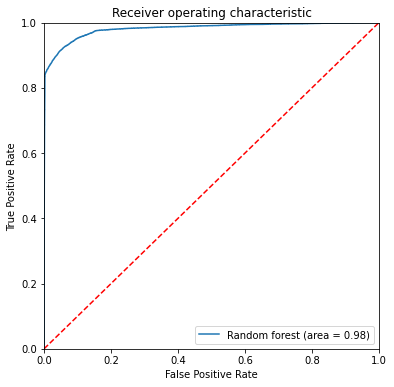

In [0]:
# ROC curve

fpr, tpr, thresholds = roc_curve(Y_test, rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Random forest (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('RandomForest_ROC')
plt.show()


#Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, Y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
probs = gnb.predict_proba(X_test)
predicted = gnb.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
auc = metrics.roc_auc_score(Y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(Y_test, predicted))
print(metrics.classification_report(Y_test, predicted))


AUC estimate: 0.937
Mean accuracy score: 0.938
[[56043   439]
 [ 3673  6686]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.96     56482
           1       0.94      0.65      0.76     10359

    accuracy                           0.94     66841
   macro avg       0.94      0.82      0.86     66841
weighted avg       0.94      0.94      0.93     66841



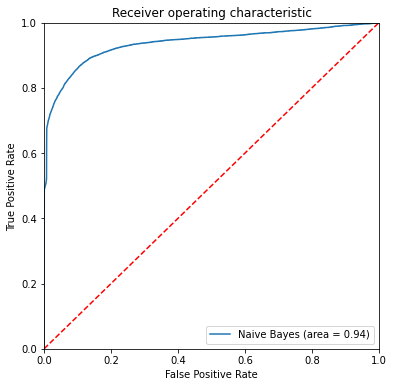

In [0]:
# ROC curve

fpr, tpr, thresholds = roc_curve(Y_test, gnb.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Naive Bayes (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('NaiveBayes_ROC')
plt.show()


#Linear Discriminant Analysis

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, Y_train)


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [0]:
probs = lda.predict_proba(X_test)
predicted = lda.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
auc = metrics.roc_auc_score(Y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(Y_test, predicted))
print(metrics.classification_report(Y_test, predicted))


AUC estimate: 0.95
Mean accuracy score: 0.905
[[56072   410]
 [ 5915  4444]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     56482
           1       0.92      0.43      0.58     10359

    accuracy                           0.91     66841
   macro avg       0.91      0.71      0.77     66841
weighted avg       0.91      0.91      0.89     66841



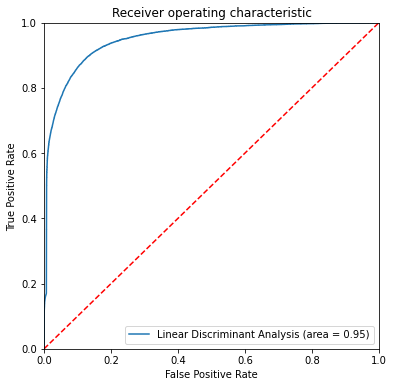

In [0]:
# ROC curve

fpr, tpr, thresholds = roc_curve(Y_test, lda.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Linear Discriminant Analysis (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('LDA_ROC')
plt.show()


#Gradient Boosting - WINNER

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

gradboost = GradientBoostingClassifier(n_estimators=200,max_depth=3)
gradboost.fit(X_train, Y_train)


NameError: ignored

In [0]:
probs = gradboost.predict_proba(X_test)
predicted = gradboost.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
auc = metrics.roc_auc_score(Y_test, probs[:, 1])

# generate evaluation metrics
print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(Y_test, predicted))
print(metrics.classification_report(Y_test, predicted))


AUC estimate: 0.987
Mean accuracy score: 0.975
[[56232   250]
 [ 1428  8931]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     56482
           1       0.97      0.86      0.91     10359

    accuracy                           0.97     66841
   macro avg       0.97      0.93      0.95     66841
weighted avg       0.97      0.97      0.97     66841



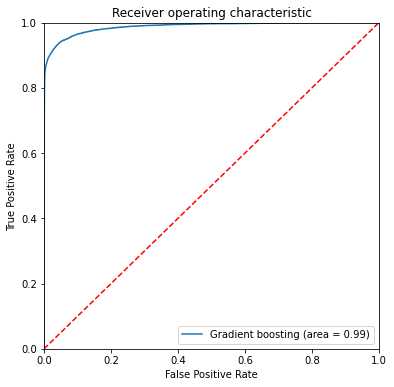

In [0]:
# ROC curve

fpr, tpr, thresholds = roc_curve(Y_test, gradboost.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Gradient boosting (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('GradientBoost_ROC')
plt.show()


# Logistic regression

In [0]:
# Logistic regression
model2 = LogisticRegression()
model2.fit(X_train, Y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
# generate evaluation metrics

probs = model2.predict_proba(X_test)
predicted = model2.predict(X_test)
accuracy = accuracy_score(Y_test, predicted)
auc = metrics.roc_auc_score(Y_test, probs[:, 1])

print(f'AUC estimate: {auc:.3}')
print(f'Mean accuracy score: {accuracy:.3}')
print(metrics.confusion_matrix(Y_test, predicted))
print(metrics.classification_report(Y_test, predicted))


AUC estimate: 0.959
Mean accuracy score: 0.943
[[56036   446]
 [ 3372  6987]]
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     56482
           1       0.94      0.67      0.79     10359

    accuracy                           0.94     66841
   macro avg       0.94      0.83      0.88     66841
weighted avg       0.94      0.94      0.94     66841



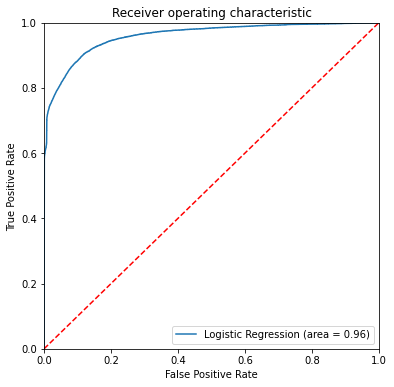

In [0]:
# ROC curve

fpr, tpr, thresholds = roc_curve(Y_test, model2.predict_proba(X_test)[:,1])
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


# Support Vector Machines - Super Slow (Do not Run)

In [0]:
#Things to try 


# standardize numeric value

#mapper = DataFrameMapper([
        #(['loan_amnt'], [Imputer(), StandardScaler()]),
        #(['int_rate_n'], [Imputer(), StandardScaler()]),
        #(['annual_inc'], [Imputer(), StandardScaler()]),
        #(['dti'], [Imputer(), StandardScaler()]),
        #(['delinq_2yrs'], [StandardScaler()]),
        #(['inq_last_6mths'], [Imputer(), StandardScaler()]),
        #(['chargeoff_within_12_mths'], [Imputer(), StandardScaler()]),
        #(['open_acc'], [Imputer(), StandardScaler()]),
        #(['pub_rec'], [Imputer(), StandardScaler()]),
        #(['pub_rec_bankruptcies'], [Imputer(), StandardScaler()]),
        #(['revol_bal'], [Imputer(), StandardScaler()]),
        #(['revol_util_n'], [Imputer(), StandardScaler()]),
        #(['total_acc'], [Imputer(), StandardScaler()]),
        #(['year'], [Imputer(), StandardScaler()]),
        #(['earliest_cr_line_n'], [Imputer(), StandardScaler()]),
        #(['fico_avg'], [Imputer(), StandardScaler()]),
        #(['desc1'], [StandardScaler()]),
        #(['installment'], [Imputer(), StandardScaler()]),
    #])

#X_train = mapper.fit_transform(X_train)
#X_test = mapper.transform(X_test)
#

In [0]:
threshold=np.arange(0.1,1,0.1)
recall_gb_all=[]
for i in threshold:
    predicted_proba_gb_all = gradboost.predict_proba(X_test)
    predicted_gb_all= (predicted_proba_gb_all[:,1] >= i).astype('int')
    recall=float(classification_report(Y_test, predicted_gb_all).split()[11])
    recall_gb_all.append(recall)
recall_gb_all


NameError: ignored

In [0]:
f1_gb_all=round(f1_score(Y_test,gradboost.predict(X_test)),3)


In [0]:
threshold=np.arange(0.1,1,0.1)
f1_gb_all_list=[]
for i in threshold:
    predicted_proba_gb_all = gradboost.predict_proba(X_test)
    predicted_gb_all= (predicted_proba_gb_all[:,1] >= i).astype('int')
    f1_all=round(f1_score(Y_test,predicted_gb_all),2)
    f1_gb_all_list.append(f1_all)
f1_gb_all_list


In [0]:
import seaborn as sn
cm=metrics.confusion_matrix(Y_test,gradboost.predict(X_test))
print(cm)
sn.heatmap(cm)


In [0]:
importance=gradboost.feature_importances_

In [0]:
zipped=dict(zip(observations.columns[1:].tolist(),importance))


In [0]:
imp = pd.DataFrame().append(zipped, ignore_index=True).T.sort_values(by=0,ascending=False)
imp
